<a href="https://colab.research.google.com/github/hellocybernetics/TensorFlow_Eager_Execution_Tutorials/blob/master/tutorials/03_advanced/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 64kB/s 
    100% |████████████████████████████████| 3.0MB 8.5MB/s 
    100% |████████████████████████████████| 419kB 11.2MB/s 
    100% |████████████████████████████████| 61kB 23.1MB/s 


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

L = tf.keras.layers
metrics = tf.keras.metrics

In [0]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100

In [4]:
train_data, test_data = tf.keras.datasets.mnist.load_data()

N = train_data[0].shape[0]
N

11493376/11490434 [==============================] - 0s 0us/step


60000

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_data[0].reshape(-1, 28, 28, 1).astype(np.float32) / 255, 
    train_data[1].astype(np.int32)
)).batch(batch_size).shuffle(10000)

train_dataset

<ShuffleDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>

### Discriminator
Discriminator $D(x, \phi)$ は入力データ $ x $ が本物の画像か偽物の画像かを見分ける役割を担う。これは2クラス分類のためにシグモイド関数を出力の活性化関数に用いている。

In [6]:
D = tf.keras.Sequential([
    L.InputLayer([28, 28, 1]),
    L.Flatten(),
    L.Dense(hidden_size, activation=tf.nn.leaky_relu),
    L.Dense(hidden_size, activation=tf.nn.leaky_relu),
    L.Dense(1, activation=tf.nn.sigmoid),
])

D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 267,009
Trainable params: 267,009
Non-trainable params: 0
_________________________________________________________________


### Generator
Generator $G(z, \theta)$ は乱数$z$を入力すると適当な画像を出力する。下記のコードでは $28 \times 28$ ピクセルの画像を返す。$G(z, \theta)$が生成した画像が、GANにおいては「偽物の画像」という扱いである。出力の活性化関数は $\rm tanh(\cdot)$ であるが。画像として出力する場合後述の通り、$ (0, 1)$になるよう値域を操作する。

In [7]:
G = tf.keras.Sequential([
    L.InputLayer([latent_size]),
    L.Dense(hidden_size, activation=tf.nn.relu),
    L.Dense(hidden_size, activation=tf.nn.relu),
    L.Dense(784, activation=tf.nn.tanh),
    L.Reshape([28, 28, 1])
])

G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 283,920
Trainable params: 283,920
Non-trainable params: 0
_________________________________________________________________


### 損失関数
損失関数にはバイナリクロスエントロピーを利用する。GANのもともとの問題設定は下記である。$D$ は画像が偽物であるか本物であるかを見分ける2クラス分類に強くなるように学習し、一方で、 $G$ は$D$ が分類に間違えるように（すなわち本物の近い画像を作り出せるように）学習する意図がある。


$$
\begin{align}
G^\ast&={\rm arg}\min_G \max_D V(G,D) \\
V(G,D)&=\mathbb{E}_{x\sim p_t(x)} \left[ \log D(x) \right] + \mathbb{E}_{{\bf z}\sim p_{\bf z}({\bf z})} \left[ \log\left( 1-D\left( G({\bf z}) \right) \right) \right]
\end{align}
$$

`denorm`関数は、画像を $(0, 1)$に変更するための処理である。

In [0]:
def loss_fn(y, y_pre):
    return tf.reduce_sum(metrics.binary_crossentropy(y, y_pre))

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

def denorm(x):
    out = (x + 1) / 2
    return tf.clip_by_value(x, 0, 1)

### Discriminatorの更新
$D(x, \phi)$のパラメータ $\phi$を更新する場合は、$G(z, \theta)$の方は固定したものを利用する。具体的には下記のような流れである。

1 : 偽物画像
$
x^{*} =  G(z, \theta)
$
を生成する。

2 : 本物画像 $x$  を準備する。

3 : 偽物$x^{*}$に対する$D$ の予想
$
y^{*} = D(x^{*}, \phi)
$
を計算する。

4 : 本物$x$に対する$D$ の予想
$
y = D(x, \phi)
$
を計算する。

5 : 下記の損失関数を計算する（$\sum$はミニバッチデータに対しての和）。

$$
\sum [\log(y) - \log(1 - y^{*})]
$$

6: $D(x, \phi)$ のパラメータ$\phi$についてのみ勾配を計算しパラメータの更新をする。

上記の流れを実現するコードは下記になる。
`with tf.GradientTape() as g`のコンテキスト内で、`g.watch(D.variables)`とすることで、`D`の含まれているパラメータのみ勾配計算のための計算グラフを準備していることに注意（別にこうせずに、全部の勾配を求める準備をしておきつつ、パラメータの更新を行うときに、`D.variables`だけを更新するというふうにできるが、無駄な計算は省くに越したことはない。

In [0]:
@tf.function
def D_train(images):
    real_labels = tf.ones([batch_size, 1])
    fake_labels = tf.zeros([batch_size, 1])    

    # Compute BCE_Loss using real images where BCE_Loss(x, y): 
    #         - y * log(D(x)) - (1-y) * log(1 - D(x))
    # Second term of the loss is always zero since real_labels == 1
    
    with tf.GradientTape() as g:
        g.watch(D.variables)
        outputs = D(images)
        d_loss_real = loss_fn(real_labels, outputs)
    
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = tf.random.normal([batch_size, latent_size])
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = loss_fn(fake_labels, outputs)
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
    
    grads = g.gradient(d_loss, D.variables)
    optimizer.apply_gradients(zip(grads, D.variables))
    
    return d_loss

### Generatorの更新
こちらでは $D(x, \phi)$を固定する。

1. $z^{*} \sim \mathcal N(0, 1) $として乱数生成

2.  偽物画像 $x^{*} = G(z^{*} , \theta)$ を生成。

3.  偽物に対する予想  $y^{*} = D(x^*, \phi)$ を得る。

4. 下記の損失関数を計算する

$$
\sum [ \log(1-y^{*})]
$$

5. $G(z, \theta)$のパラメータ $\theta$に関して勾配を計算し、更新を行う。

In [0]:
@tf.function
def G_train():
    real_labels = tf.ones([batch_size, 1])
    # Compute loss with fake images
    z = tf.random.normal([batch_size, latent_size])
    
    with tf.GradientTape() as g:
        g.watch(G.variables)
        fake_images = G(z)
        outputs = D(fake_images)

        # https://arxiv.org/pdf/1406.2661.pdf
        g_loss = loss_fn(real_labels, outputs)

    # Backprop and optimize
    grads = g.gradient(g_loss, G.variables)
    optimizer.apply_gradients(zip(grads, G.variables))    

    return g_loss

In [21]:
# Start training
total_step = N // batch_size
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_dataset):

        with tf.device("/gpu:0"):

            d_loss = D_train(images)

            g_loss = G_train()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, num_epochs, i+1, total_step, 
                          d_loss.numpy(), g_loss.numpy()))

Epoch [0/200], Step [200/600], d_loss: 4.0488, g_loss: 1686.2761
Epoch [0/200], Step [400/600], d_loss: 1.8472, g_loss: 1589.1348
Epoch [0/200], Step [600/600], d_loss: 2.8169, g_loss: 1413.5577
Epoch [1/200], Step [200/600], d_loss: 6.7009, g_loss: 1109.8677
Epoch [1/200], Step [400/600], d_loss: 31.9832, g_loss: 440.0898
Epoch [1/200], Step [600/600], d_loss: 72.2874, g_loss: 249.9580
Epoch [2/200], Step [200/600], d_loss: 16.2719, g_loss: 459.8261
Epoch [2/200], Step [400/600], d_loss: 10.7180, g_loss: 549.2604
Epoch [2/200], Step [600/600], d_loss: 15.6858, g_loss: 722.9628
Epoch [3/200], Step [200/600], d_loss: 11.7751, g_loss: 737.8537
Epoch [3/200], Step [400/600], d_loss: 4.8618, g_loss: 472.0880
Epoch [3/200], Step [600/600], d_loss: 12.4410, g_loss: 566.3632
Epoch [4/200], Step [200/600], d_loss: 1.7589, g_loss: 566.5804
Epoch [4/200], Step [400/600], d_loss: 4.6200, g_loss: 715.2528
Epoch [4/200], Step [600/600], d_loss: 10.5105, g_loss: 615.5042
Epoch [5/200], Step [200/600

In [0]:
image_generated = denorm(G(tf.random.normal([10, latent_size])))

In [0]:
image_generated_numpy = image_generated.numpy().reshape(-1, 28, 28)

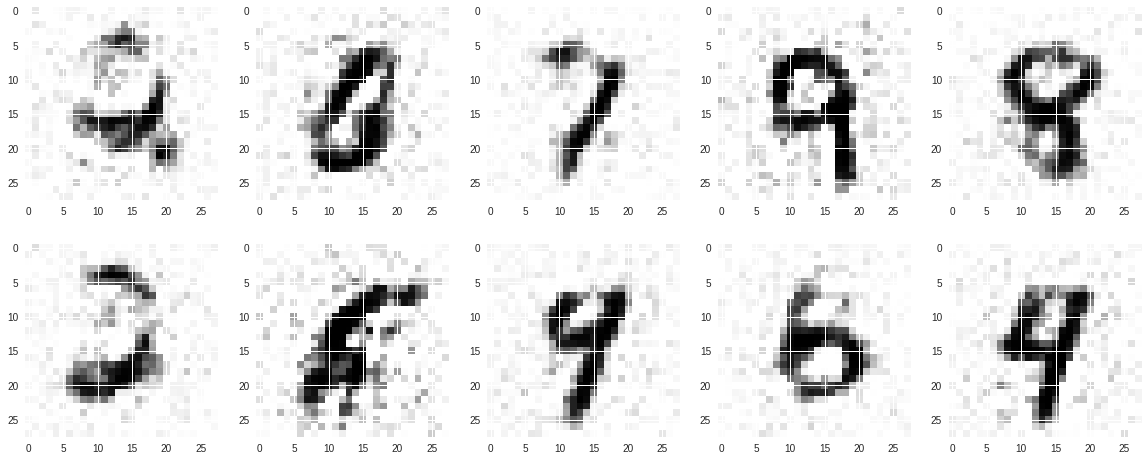

In [25]:
plt.figure(figsize=(20, 8))
for i, img_show in enumerate(image_generated_numpy):
    plt.subplot(2, 5, i+1)
    plt.imshow(img_show)